<br>

# Date 04/02/2025
# Remaking parasitemia graphs in log10 scale after adjusting the Hill Equation

<br>

In [73]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 

## Function to run the simulation by adjusting weight group

In [79]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_lum", "0",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

### Adjust weight groups by modifying the weight_values list below - the rest is automated

In [81]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [54]

for weight in weight_values:

    #Run the simulation

    efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

    # Save the DataFrame to a pickle file
    df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

    # Save the DataFrame to a CSV file
    df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)

    print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
    print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-11 

Length of simulation:  0:00:10.904682 


The failed treatment count for weight 54kg is: 99

The percentage efficacy for weight 54kg is: 1.0 



<br>

## Plotting the parasite density for each weight group

In [23]:
# Load the dataframes from pyobj 

weight_dataframes = []

for weight in weight_values:
    # Load the DataFrame from a pickle file
    dataframe = pd.read_pickle(f"df_weight_{weight}kg.pyobj")
    # Append to the list
    weight_dataframes.append(dataframe)

In [24]:
# Calculate the failed treatment counts and efficacy for each weight 

failed_treatment_counts = []
efficacies = []
df_efficacy = pd.DataFrame()

for df_weight in weight_dataframes:
    if df_weight['PARASITEDENSITY'].isna().any():
        failed_treatment_count = np.nan
    else:
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
    
    total_patients = df_weight['PID'].nunique()
    if total_patients == 0 or np.isnan(failed_treatment_count): 
        efficacy = np.nan
    else:
        percentage_failed = (failed_treatment_count / total_patients) * 100
        efficacy = (100 - percentage_failed)
        if np.isnan(efficacy):
            efficacy = np.nan

    failed_treatment_counts.append(failed_treatment_count)
    efficacies.append(efficacy)

df_efficacy['Weight'] = weight_values
df_efficacy['Failed Treatment Count'] = failed_treatment_counts
df_efficacy['Efficacy'] = efficacies

# Store the dataframes from weight_dataframes in a dictionary
weight_dataframes_dict = {weight: df for weight, df in zip(weight_values, weight_dataframes)}


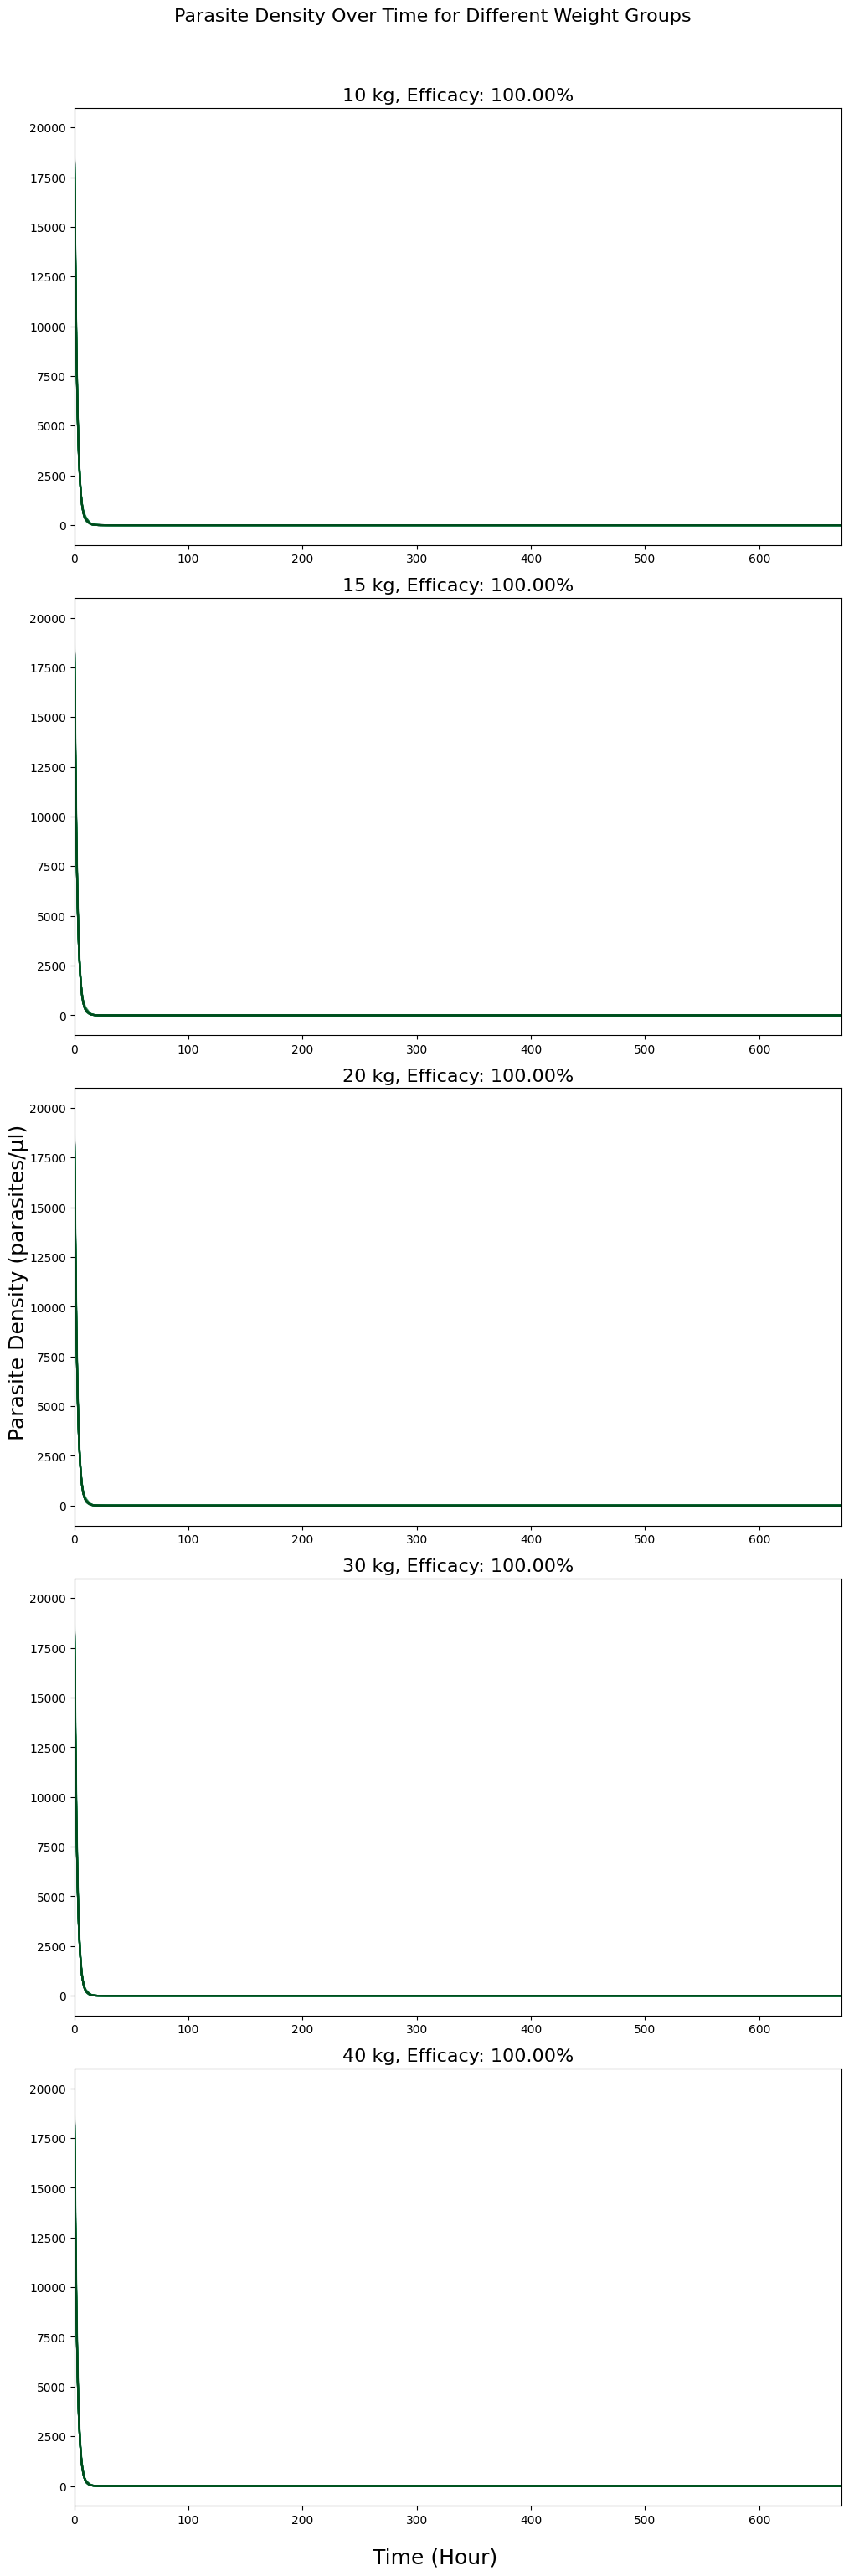

In [25]:
import math

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(5, 1, figsize=(10, 30), sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate(weight_values):
    df_weight = weight_dataframes_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    efficacy = df_efficacy[df_efficacy["Weight"] == weight]["Efficacy"].values[0]
    ax[i].set_title(f'{weight} kg, Efficacy: {efficacy:.2f}%', fontsize=16)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()  # Create a copy to avoid SettingWithCopyWarning

        # Log transform the parasite density and store it in a new column
        #df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.00000000000001)  # Log transformation
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)

        #ax[i].set_xlabel('Time (Hour)', fontsize=16)
        #ax[i].set_ylabel('Log10 Parasite Density', fontsize=16)

    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)

    #Change y-axis limit to 6 to -6
    #ax[i].set_ylim(0, 6)
        
    
# Add common y-axis label
fig.text(-0.01, 0.5, 'Parasite Density (parasites/μl)', va='center', rotation='vertical', fontsize=18)
# Add common x-axis label
fig.text(0.5, -0.01, 'Time (Hour)', ha='center', fontsize=18)

# Add a common title
fig.suptitle('Parasite Density Over Time for Different Weight Groups \n ', y = 1, va='center',fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_parasite_density.png")


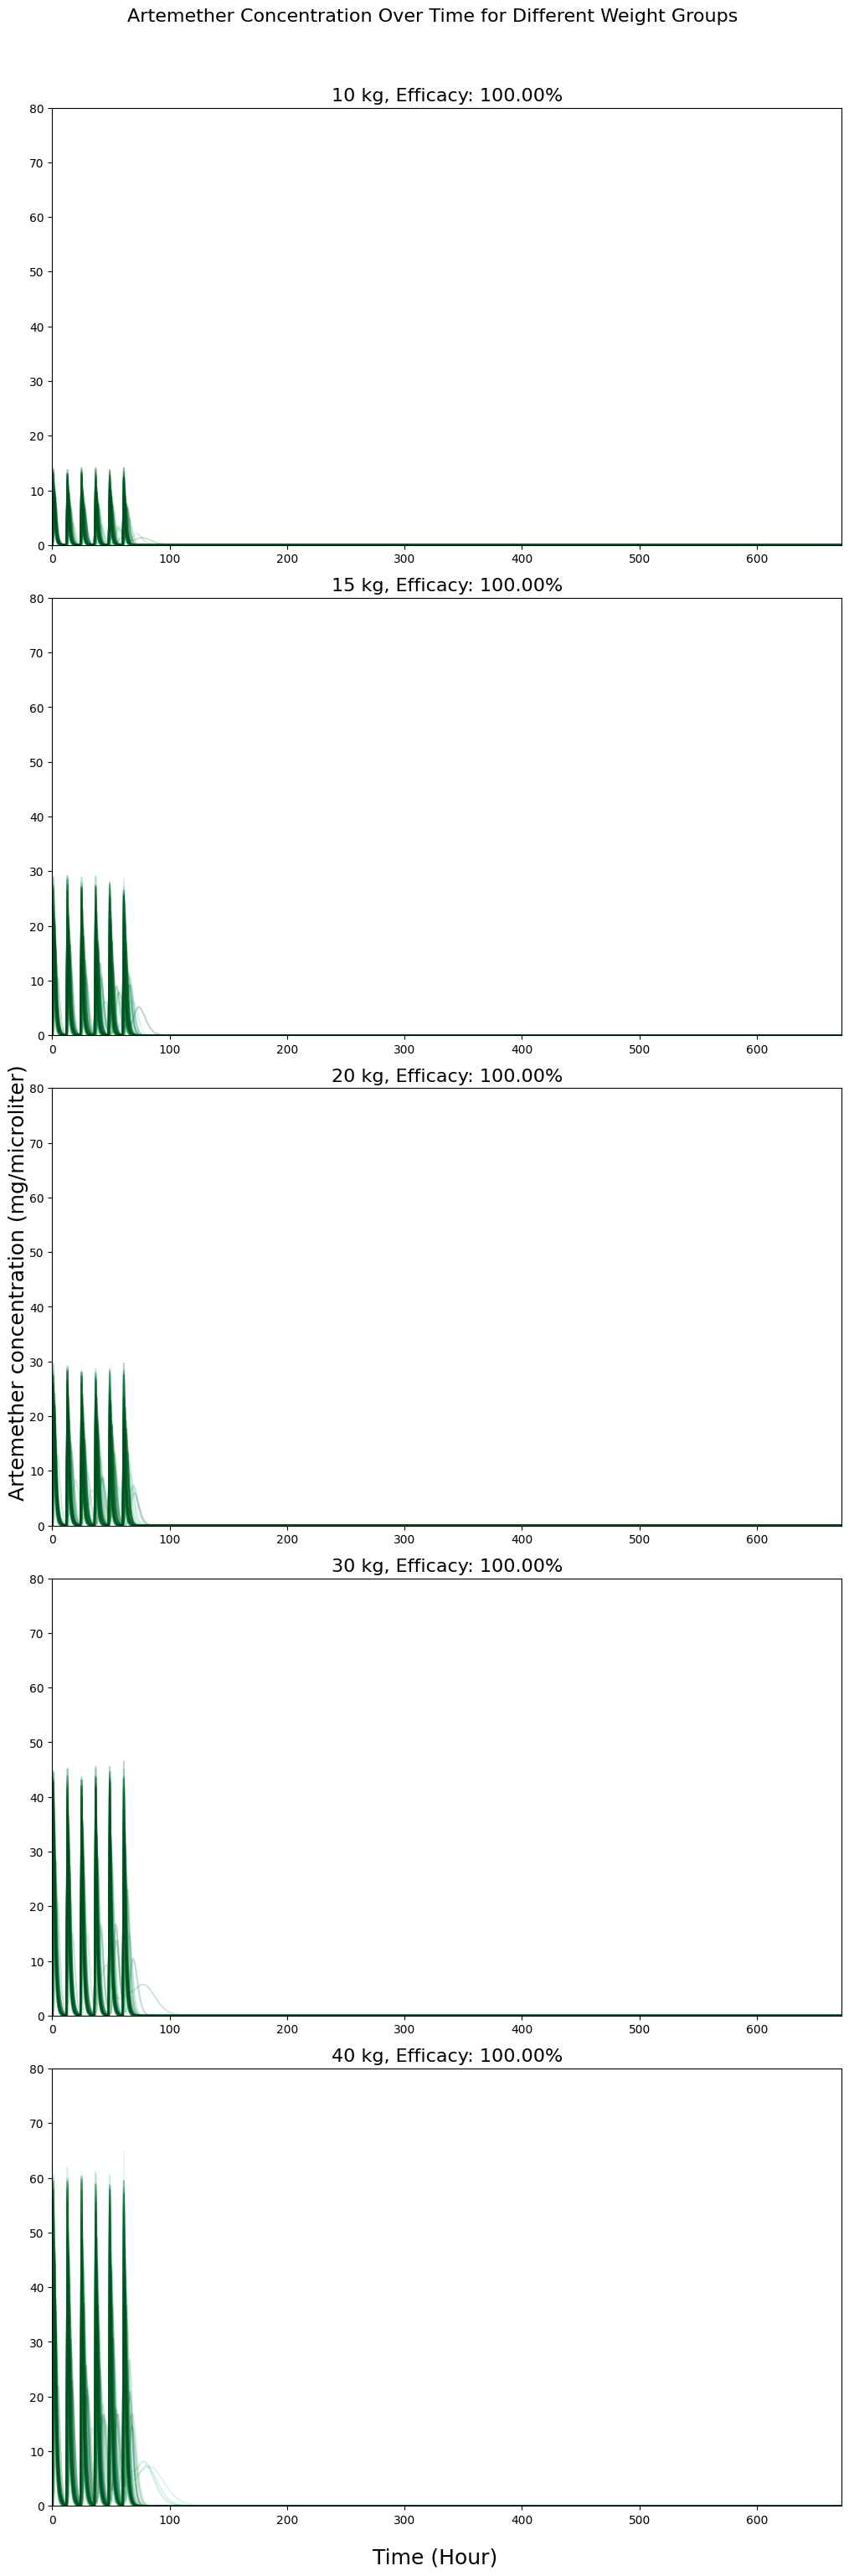

In [27]:
import math

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(5, 1, figsize=(10, 30), sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate(weight_values):
    df_weight = weight_dataframes_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    efficacy = df_efficacy[df_efficacy["Weight"] == weight]["Efficacy"].values[0]
    ax[i].set_title(f'{weight} kg, Efficacy: {efficacy:.2f}%', fontsize=16)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()  # Create a copy to avoid SettingWithCopyWarning

        # Log transform the parasite density and store it in a new column
        #df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.00000000000001)  # Log transformation
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

        #ax[i].set_xlabel('Time (Hour)', fontsize=16)
        #ax[i].set_ylabel('Log10 Parasite Density', fontsize=16)

    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)

    #Change y-axis limit 
    ax[i].set_ylim(0, 80)
        
    
# Add common y-axis label
fig.text(-0.01, 0.5, 'Artemether concentration (mg/microliter)', va='center', rotation='vertical', fontsize=18)
# Add common x-axis label
fig.text(0.5, -0.01, 'Time (Hour)', ha='center', fontsize=18)

# Add a common title
fig.suptitle('Artemether Concentration Over Time for Different Weight Groups \n ', y = 1, va='center',fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_artemether.png")


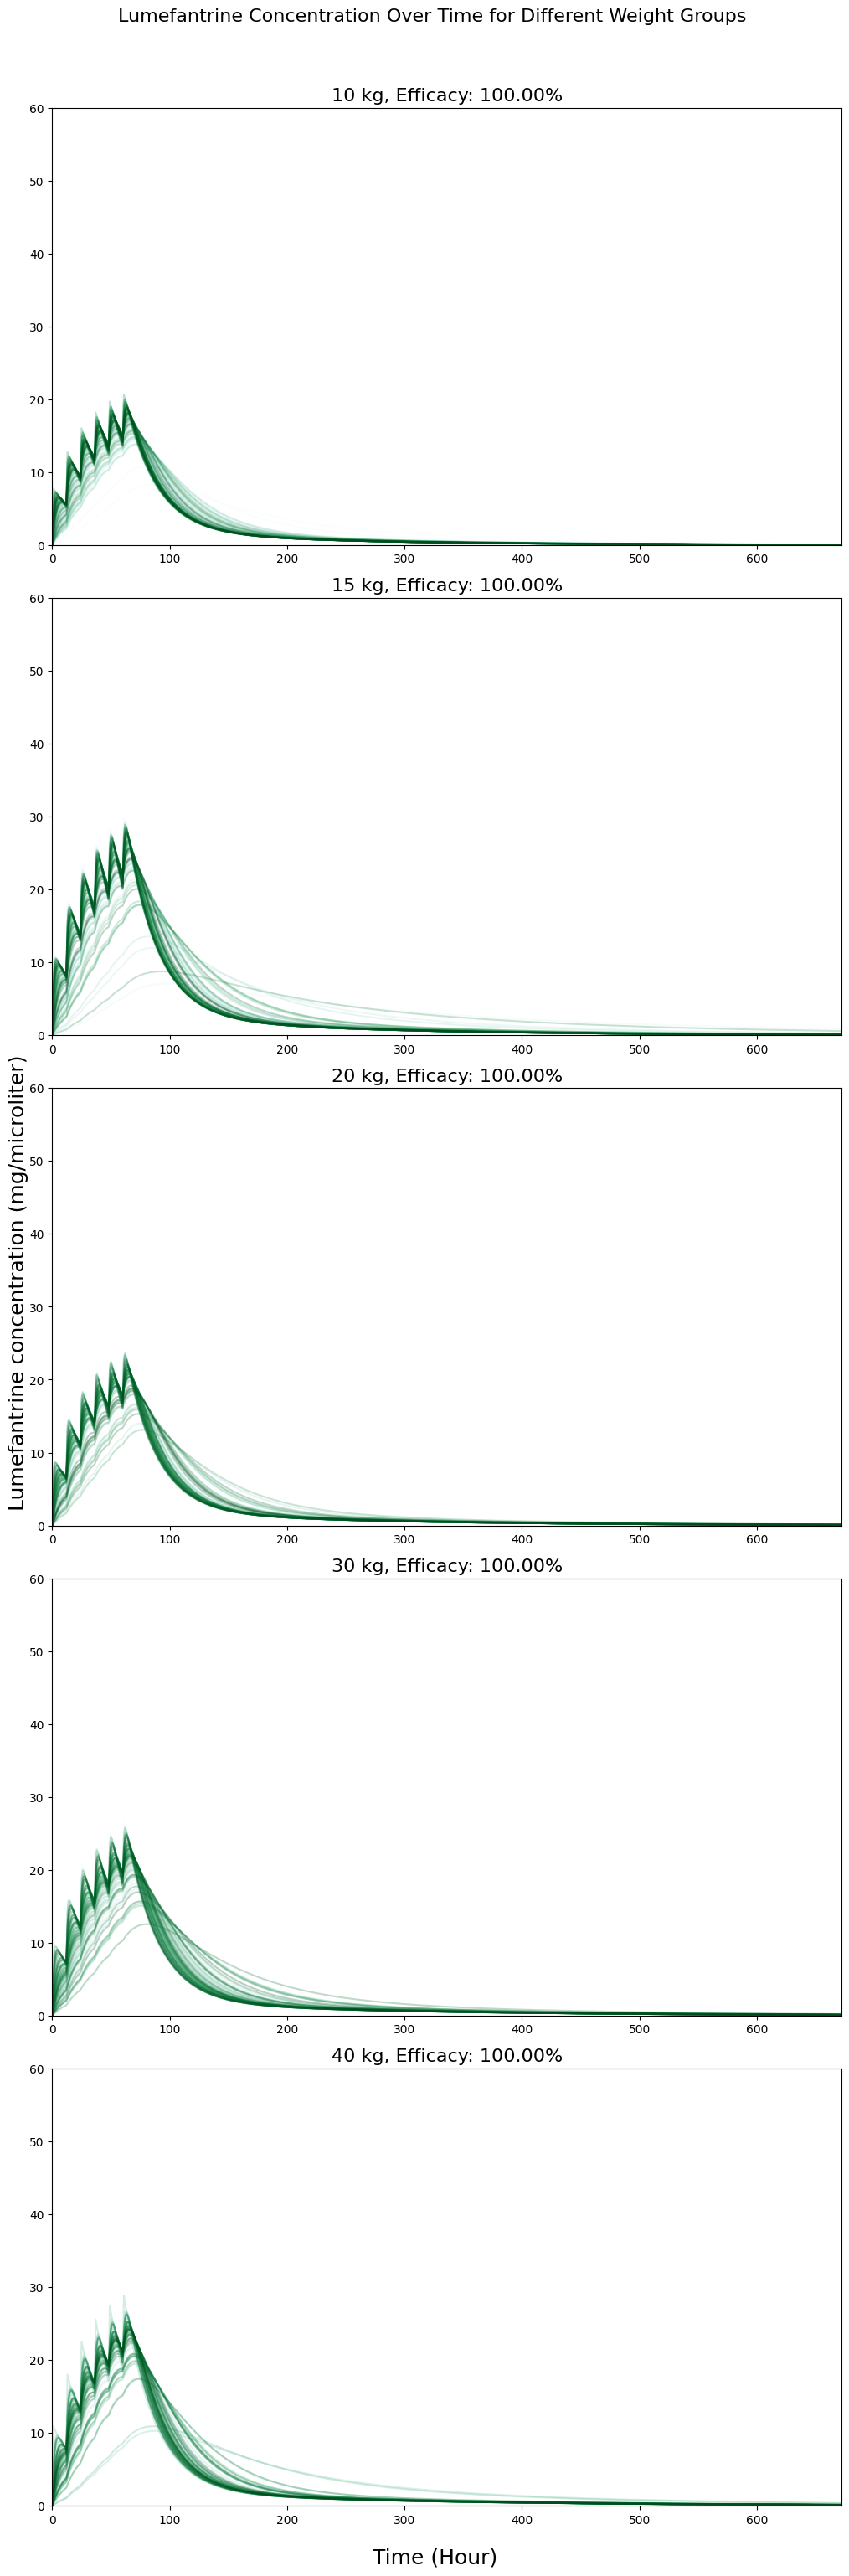

In [28]:
import math

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(5, 1, figsize=(10, 30), sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate(weight_values):
    df_weight = weight_dataframes_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    efficacy = df_efficacy[df_efficacy["Weight"] == weight]["Efficacy"].values[0]
    ax[i].set_title(f'{weight} kg, Efficacy: {efficacy:.2f}%', fontsize=16)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()  # Create a copy to avoid SettingWithCopyWarning

        # Log transform the parasite density and store it in a new column
        #df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.00000000000001)  # Log transformation
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

        #ax[i].set_xlabel('Time (Hour)', fontsize=16)
        #ax[i].set_ylabel('Log10 Parasite Density', fontsize=16)

    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)

    #Change y-axis limit 
    ax[i].set_ylim(0, 60)
        
    
# Add common y-axis label
fig.text(-0.01, 0.5, 'Lumefantrine concentration (mg/microliter)', va='center', rotation='vertical', fontsize=18)
# Add common x-axis label
fig.text(0.5, -0.01, 'Time (Hour)', ha='center', fontsize=18)

# Add a common title
fig.suptitle('Lumefantrine Concentration Over Time for Different Weight Groups \n ', y = 1, va='center',fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_lumefantrine.png")
